In [32]:
# Version 2025-07-28

# All basis code provided by H&M
# Edited by Patrik Johansson
# Imported functions are created by H&M unless open source
import sys
sys.path.append('/home/jupyter/')
import os

import numpy as np
import pandas as pd
import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt

# Special methods written by H&M
from stats import reqSS_means
from plotting import plot_summary

from numpy.random import default_rng

colors = sns.color_palette()

In [33]:
alpha = 0.05 # significance level
beta = 0.2 # type 2 error rate, test power is 1 - beta
mde = 0.05 # 0.01 and 0.05 optimally, but was at start = 0.1

# control group
mu_c = 3
var_c = 1
# treatment group
mu_t = mu_c*(1.+(mde))
var_t = 1


# number of observations for control
nobs_c = reqSS_means(mu_c, var_c, mde, alpha, beta, direction = "two-sided")
# nobs_c = 1000*(nobs_c//1000)+1000
nobs_c_x2 = nobs_c*2

# number of observations for treatment 
nobs_t = reqSS_means(mu_c, var_c, mde, alpha, beta, direction = "two-sided")
# nobs_t = 1000*(nobs_t//1000)+1000
nobs_t_x2 = nobs_t*2

# number of experiments
n_exps = 200

# obs_step = 100

# alternative: two-sided, less, greater
alternative = "two-sided"

In [34]:
rand_gen = default_rng(seed=42)

In [35]:
def sampling(distribution, transformation, control, treatment, nobs):
    a_data = rand_gen.normal(control, np.sqrt(control), nobs)
    aa_data = rand_gen.normal(control, np.sqrt(control), nobs)
    ab_data = rand_gen.normal(treatment, np.sqrt(treatment), nobs)

In [36]:
def ab_test(dist, trans, mod, nobs, mean, var, mde, n_exps, chosen_seed, seed_change):
    rand_gen = default_rng(seed=chosen_seed)

    pvalues_aa = []
    pvalues_ab = []

    """
    print("AB_TEST")
    print(f"Dist = {dist}")
    print(f"Trans = {trans}")
    print(f"Mod = {mod}")
    print(f"nobs = {nobs}")
    print(f"mean = {mean}")
    print(f"var = {var}")
    print(f"mde = {mde}")
    print(f"n_exps = {n_exps}")
    print(f"chosen_seed = {chosen_seed}")
    print(f"seed_change = {seed_change}")
    print("\n")
    """

    treatment = mean*(1.+(mde))


    for exp_num in range(n_exps):
        
        if (seed_change > 0) and (exp_num != 0):
            chosen_seed += seed_change
            rand_gen = default_rng(seed=chosen_seed)

        #generate_data
        if dist == "Poisson":
            a_data = rand_gen.poisson(mean, int(nobs))
            aa_data = rand_gen.poisson(mean, int(nobs))
            ab_data = rand_gen.poisson(treatment, int(nobs))
        elif dist == "Discrete Uniform":
            a_data = rand_gen.integers(np.round((mean - 3*var), 0), np.round((mean + 3*var + 1), 0), int(nobs))
            aa_data = rand_gen.integers(np.round((mean - 3*var), 0), np.round((mean + 3*var + 1), 0), int(nobs))
            ab_data = rand_gen.integers(np.round(((treatment) - 3*var), 0), np.round(((treatment) + 3*var + 1), 0), int(nobs))
        else: # Normal distribution by default
            a_data = rand_gen.normal(mean, np.sqrt(var), int(nobs))
            aa_data = rand_gen.normal(mean, np.sqrt(var), int(nobs))
            ab_data = rand_gen.normal(treatment, np.sqrt(var), int(nobs))
        
        # cast arrays to handle transformations with changes
        a_data = np.array(a_data, dtype=float)
        aa_data = np.array(aa_data, dtype=float)
        ab_data = np.array(ab_data, dtype=float)

        # modify data for transformation
        if mod == 0:
            a_data[a_data <= 0] = 1
            aa_data[aa_data <= 0] = 1
            ab_data[ab_data <= 0] = 1
        elif mod == 1 or mod == 11:
            a_data += 1
            aa_data += 1
            ab_data += 1
        elif mod == 10:
            a_data[a_data <= 0] = 1e-10
            aa_data[aa_data <= 0] = 1e-10
            ab_data[ab_data <= 0] = 1e-10


        # action based on transformation used
        if trans == "Log" or trans == "Logarithmic":
            a_data = np.log(a_data)
            aa_data = np.log(aa_data)
            ab_data = np.log(ab_data) 
        elif trans == "BC" or trans == "Box-Cox":
            a_data, a_lambda = st.boxcox(a_data)
            aa_data, aa_lambda = st.boxcox(aa_data)
            ab_data, ab_lambda = st.boxcox(ab_data)

        # 11 is heuristical approach where first an addition before transformation
        # then subtracts of points after transformation
        if mod == 11:
            a_data -= 1
            aa_data -= 1
            ab_data -= 1  
  
        
        pvalues_ab.append(
            st.ttest_ind(a_data, ab_data).pvalue
        )
        pvalues_aa.append(
            st.ttest_ind(a_data, aa_data).pvalue
        )

    pvalues_ab = np.array(pvalues_ab)
    pvalues_aa = np.array(pvalues_aa)

    return pvalues_ab, pvalues_aa

In [37]:
def approximate_points(dist, trans, mod, mean, var, points, chosen_seed, mde, alpha, beta, direction):

    """
    # Prints values
    print("APPROXIMATE_POINTS")
    print(f"Dist = {dist}")
    print(f"Trans = {trans}")
    print(f"Mod = {mod}")
    print(f"mean = {mean}")
    print(f"var = {var}")
    print(f"points = {points}")
    print(f"mde = {mde}")
    print(f"chosen_seed = {chosen_seed}")
    print(f"alpha = {alpha}")
    print(f"beta = {beta}")
    print(f"direction = {direction}")
    print("\n")
    """

    # Sets seed
    rand_gen = default_rng(seed=chosen_seed)

    if dist == "Poisson":
        data = rand_gen.poisson(mean, int(points))
    elif dist == "Discrete Uniform":
        data = rand_gen.integers(np.round((mean - 3*var), 0), np.round((mean + 3*var + 1), 0), int(points))
    else: # Normal distribution by default
        data = rand_gen.normal(mean, np.sqrt(var), int(points))
        
    data = np.array(data, dtype=float)

    # No modification by default
    if mod == 0:
        data[data <= 0] = 1
    elif mod == 1 or mod == 11:
        data += 1
    elif mod == 10:
        data[data <= 0] = 1e-10

    # No transformation by default
    if trans == "Log" or trans == "Logarithmic":
        data = np.log(data)
    elif trans == "BC" or trans == "Box-Cox":
        data, data_lambda = st.boxcox(data)

    # Heuristical modification
    if mod == 11:
        data -= 1

    mean_value = np.mean(data)
    variance = np.var(data)
        
    if direction == "greater":
        return reqSS_means(mean_value, variance, mde, alpha, beta, direction = "greater")
    if direction == "less":
        return reqSS_means(mean_value, variance, mde, alpha, beta, direction = "less")
    else:
        return reqSS_means(mean_value, variance, mde, alpha, beta, direction = "two-sided")
        

In [38]:
def complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, nexps):

    """
    # Prints values
    print("COMPLETE TEST")
    print(f"Dist = {dist}")
    print(f"Trans = {trans}")
    print(f"Mod = {mod}")
    print(f"mean = {mean}")
    print(f"var = {var}")
    print(f"points = {points}")
    print(f"nobs = {nobs}")
    print(f"mde = {mde}")
    print(f"alpha = {alpha}")
    print(f"beta = {beta}")
    print(f"direction = {direction}")
    print(f"chosen_seed = {chosen_seed}")
    print(f"seed_change = {seed_change}")
    print(f"n_exps = {nexps}")
    print("\n")
    """

    if nobs == 0:
        nobs = approximate_points(dist, trans, mod, mean, var, points, chosen_seed, mde, alpha, beta, direction)
        """
        # Prints values
        print("\n")
        print(f"new nobs = {nobs}")
        print("\n")
        """
    resultab, resultaa = ab_test(dist, trans, mod, nobs, mean, var, mde, nexps, chosen_seed, seed_change)
    return [resultab, resultaa, nobs]
    


In [ ]:
# Keywords to use
normal = "Normal"
poisson = "Poisson"
duniform = "Discrete Uniform"
bc = "BC"
log = "Log"

# Method arguments that could be easily adjused to purpose
dist = ""
trans = ""
mod = -1
mean = 3
var = 1
points = 1e6
nobs = 0
mde = 0.05
alpha = 0.05
beta = 0.2
direction = "two-sided"
chosen_seed = 42
seed_change = 1
n_exps = 200

# Below are all runs with the specific functions.

In [40]:
nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

In [41]:
#print(resn[0]) #Checks that the ab-values are correctly handeled
#print(resn[1]) #Checks that the aa-values are correctly handeled
#print(resn[2]) #Checks that the nobs is correctly handeled
#print(resp[1][0])
#print(resp[1][1])


/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

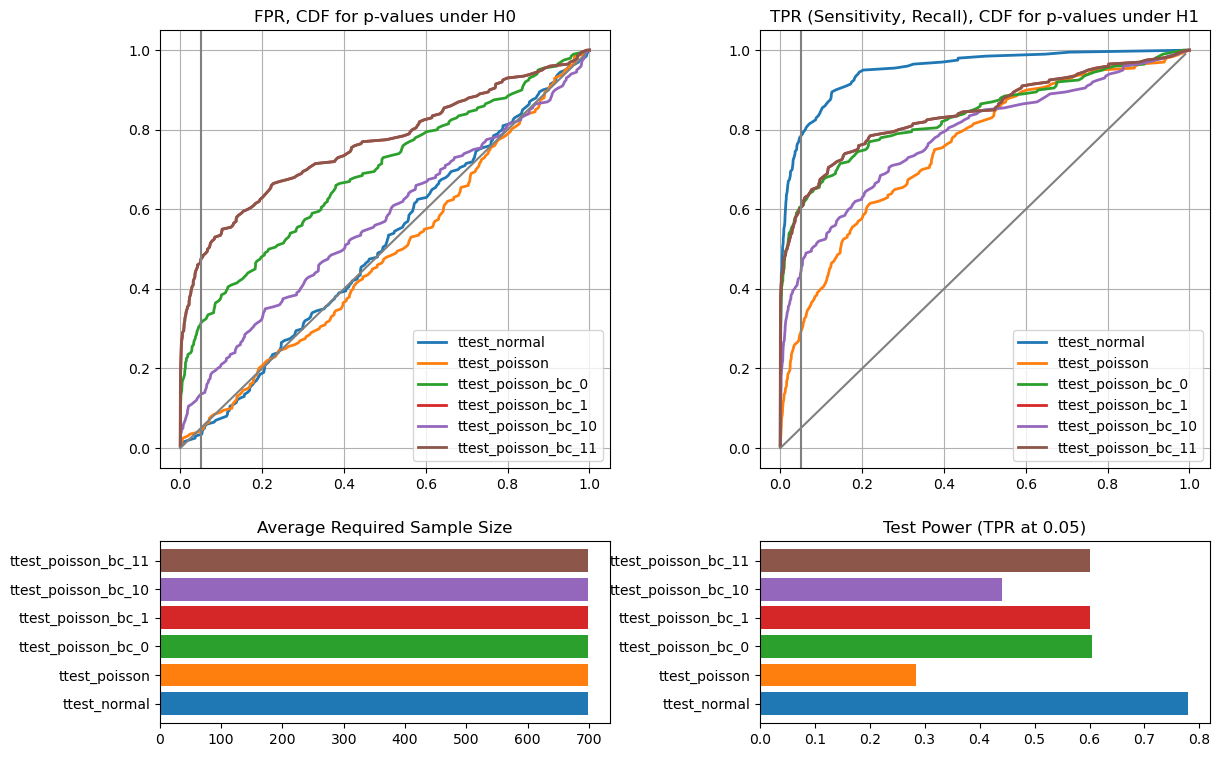

In [42]:
# First graph, + mde at fixed nobs for all bc methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [43]:
# Now the same but with log instead
nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

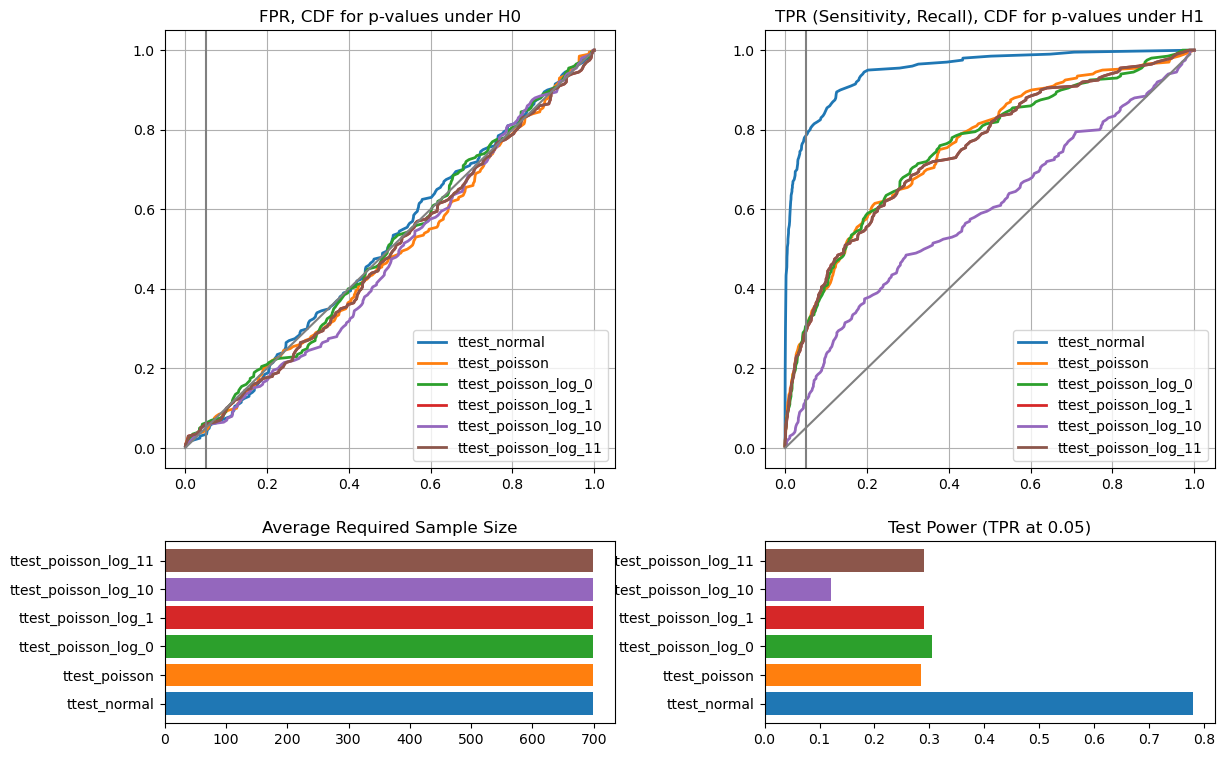

In [44]:
# First graph, + mde at fixed nobs for all log methods
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [45]:
# Now the same but nobs = 0 so that it calculates the amounts it needs.
nobs = 0
resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

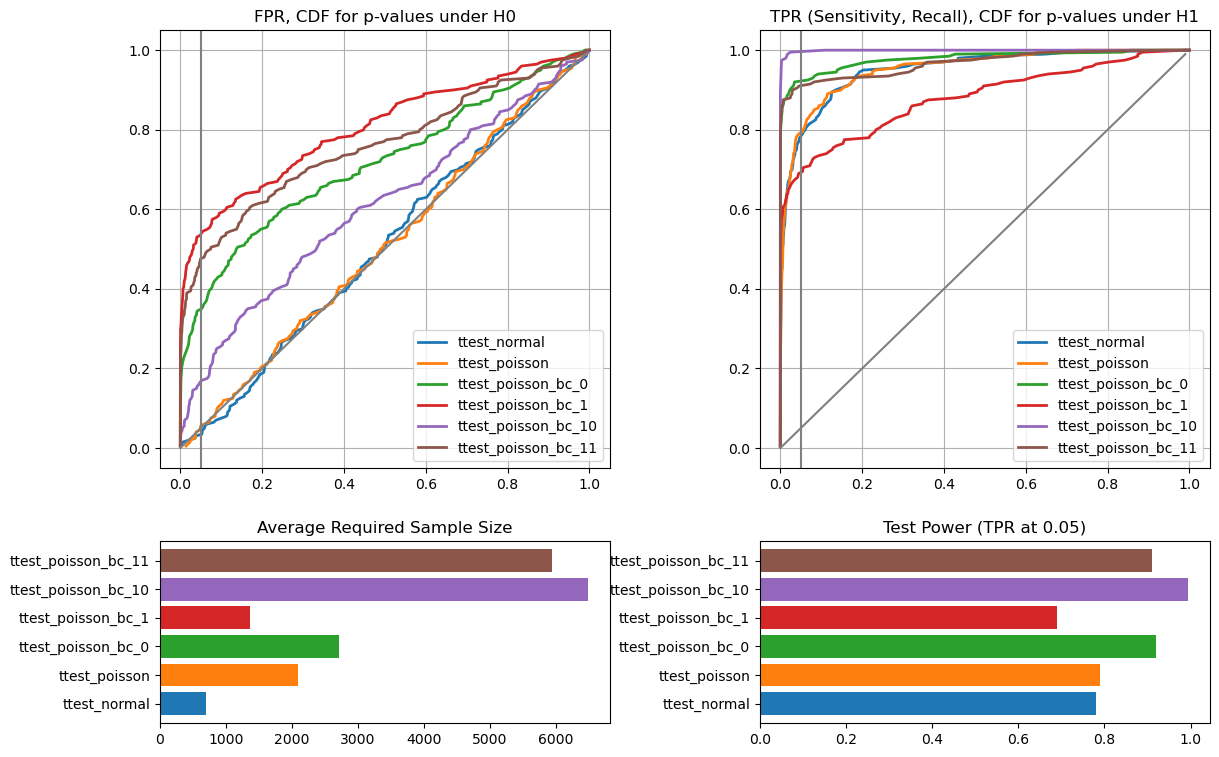

In [46]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [ ]:
# Now the same but with log instead and nobs = 0

nobs = 0

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

'\nnobs = 0\n\nresn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)\nresp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)\nresp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)\nresp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)\nresp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)\nresp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)\n'

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

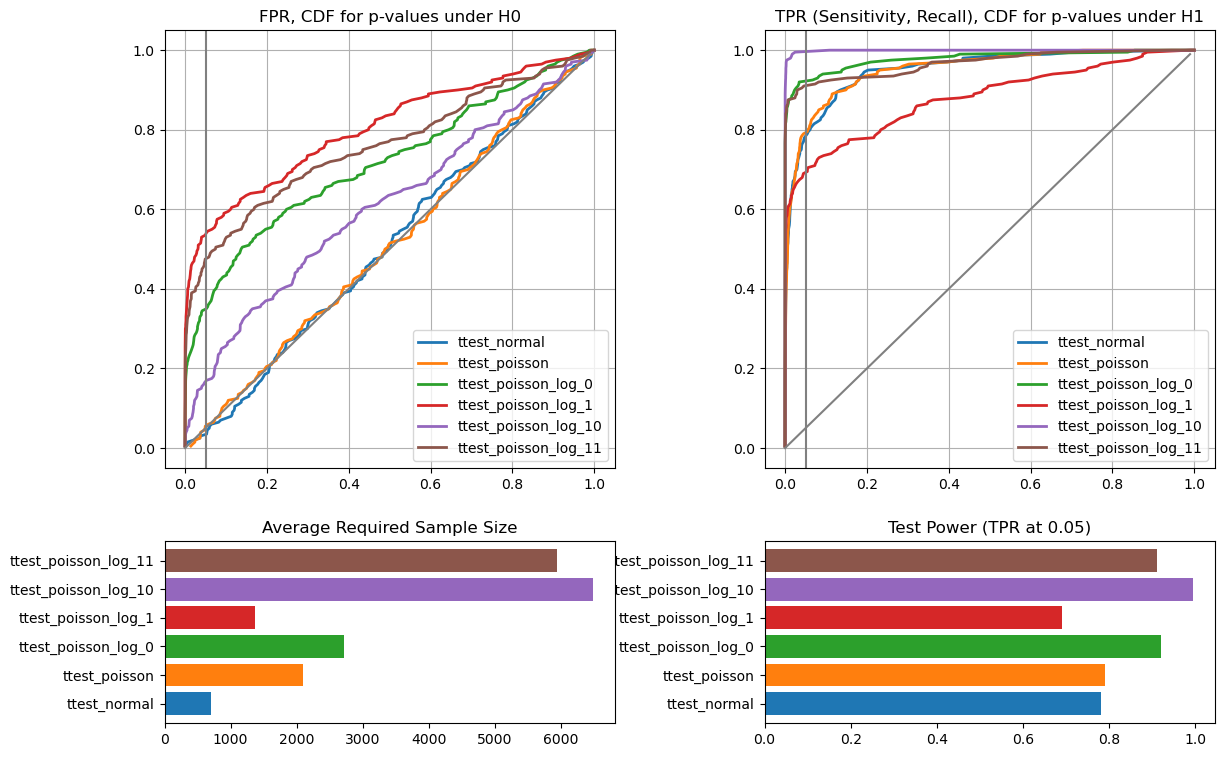

In [48]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_log_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [49]:
# Same but without the high log-approximation
nobs = 0

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
#resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

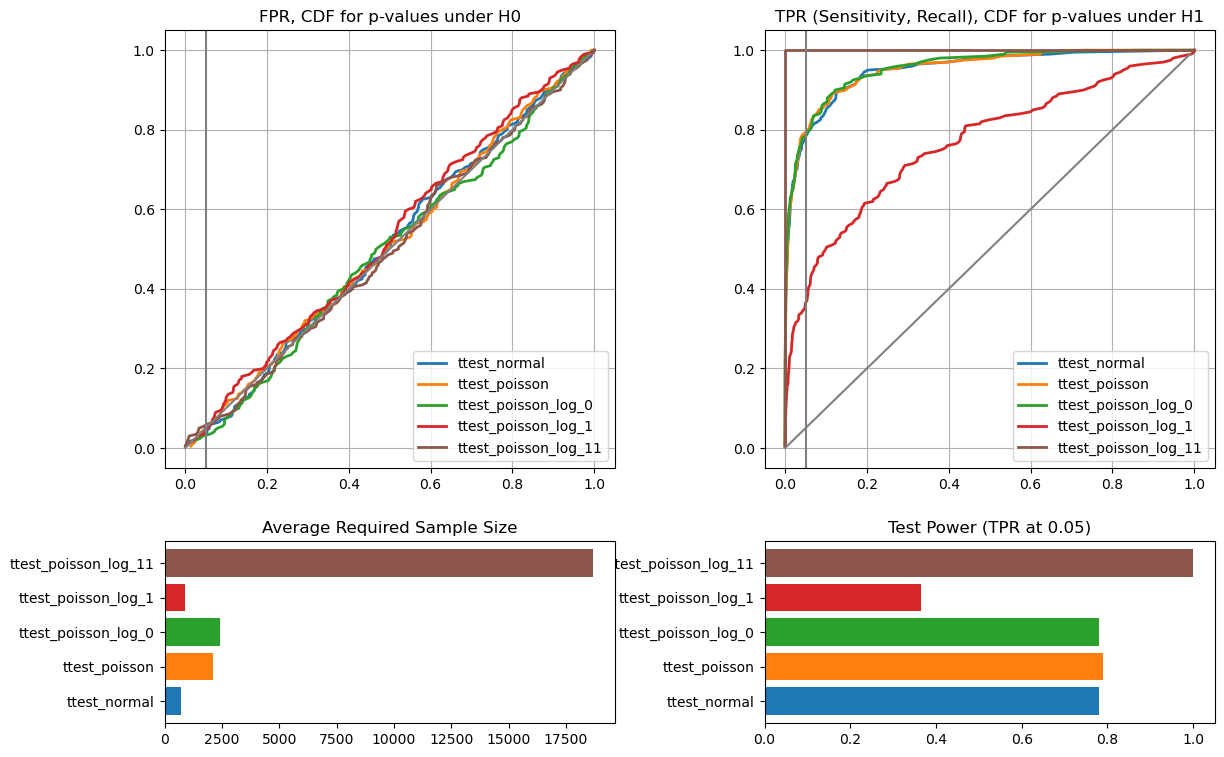

In [50]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_log_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_log_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    #"ttest_poisson_log_10": (
    #    resp10[0],
    #    resp10[1],
    #    resp10[2],
    #    colors[4]
    #),
    "ttest_poisson_log_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [51]:
# Now for discrete uniform
nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd = complete_test(duniform, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd0 = complete_test(duniform, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd1 = complete_test(duniform, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd10 = complete_test(duniform, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd11 = complete_test(duniform, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

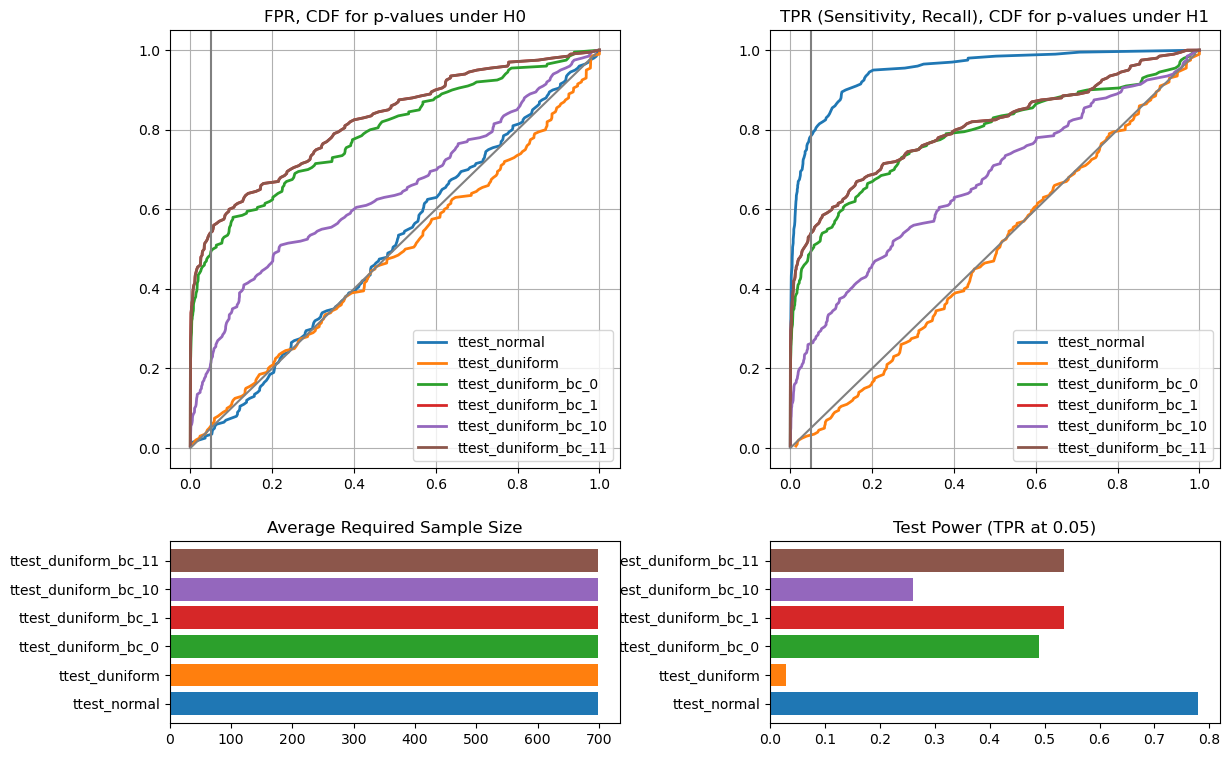

In [52]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_duniform": (
        resd[0],
        resd[1],
        resd[2],
        colors[1]
    ),
    "ttest_duniform_bc_0": (
        resd0[0],
        resd0[1],
        resd0[2],
        colors[2]
    ),
    "ttest_duniform_bc_1": (
        resd1[0],
        resd1[1],
        resd1[2],
        colors[3]
    ),
    "ttest_duniform_bc_10": (
        resd10[0],
        resd10[1],
        resd10[2],
        colors[4]
    ),
    "ttest_duniform_bc_11": (
        resd11[0],
        resd11[1],
        resd11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [53]:
# Now for discrete uniform log
nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd = complete_test(duniform, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd0 = complete_test(duniform, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd1 = complete_test(duniform, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd10 = complete_test(duniform, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd11 = complete_test(duniform, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

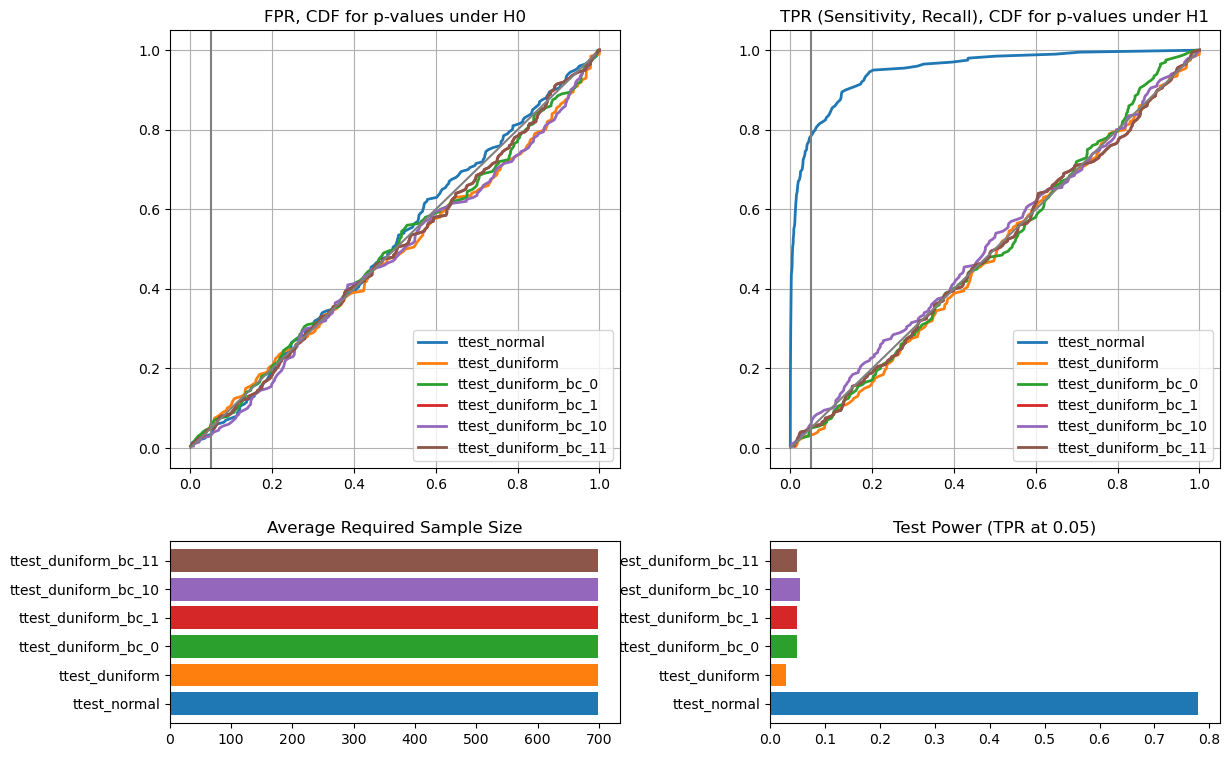

In [54]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_duniform": (
        resd[0],
        resd[1],
        resd[2],
        colors[1]
    ),
    "ttest_duniform_bc_0": (
        resd0[0],
        resd0[1],
        resd0[2],
        colors[2]
    ),
    "ttest_duniform_bc_1": (
        resd1[0],
        resd1[1],
        resd1[2],
        colors[3]
    ),
    "ttest_duniform_bc_10": (
        resd10[0],
        resd10[1],
        resd10[2],
        colors[4]
    ),
    "ttest_duniform_bc_11": (
        resd11[0],
        resd11[1],
        resd11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [55]:
# Now for discrete uniform log with their own deciding nobs
nobs = 0

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd = complete_test(duniform, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd0 = complete_test(duniform, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd1 = complete_test(duniform, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd10 = complete_test(duniform, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd11 = complete_test(duniform, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

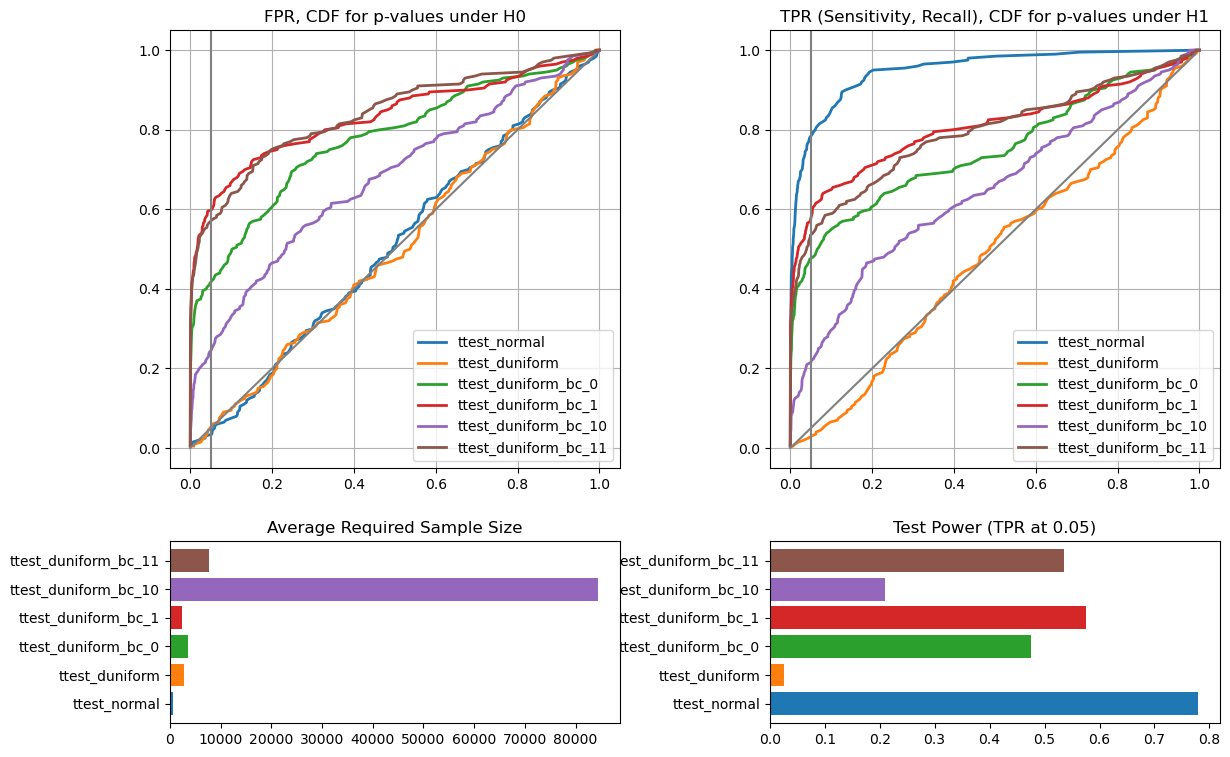

In [56]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_duniform": (
        resd[0],
        resd[1],
        resd[2],
        colors[1]
    ),
    "ttest_duniform_bc_0": (
        resd0[0],
        resd0[1],
        resd0[2],
        colors[2]
    ),
    "ttest_duniform_bc_1": (
        resd1[0],
        resd1[1],
        resd1[2],
        colors[3]
    ),
    "ttest_duniform_bc_10": (
        resd10[0],
        resd10[1],
        resd10[2],
        colors[4]
    ),
    "ttest_duniform_bc_11": (
        resd11[0],
        resd11[1],
        resd11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [57]:
# Now for discrete uniform log with their own approximations
nobs = 0

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd = complete_test(duniform, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd0 = complete_test(duniform, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd1 = complete_test(duniform, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd10 = complete_test(duniform, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resd11 = complete_test(duniform, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

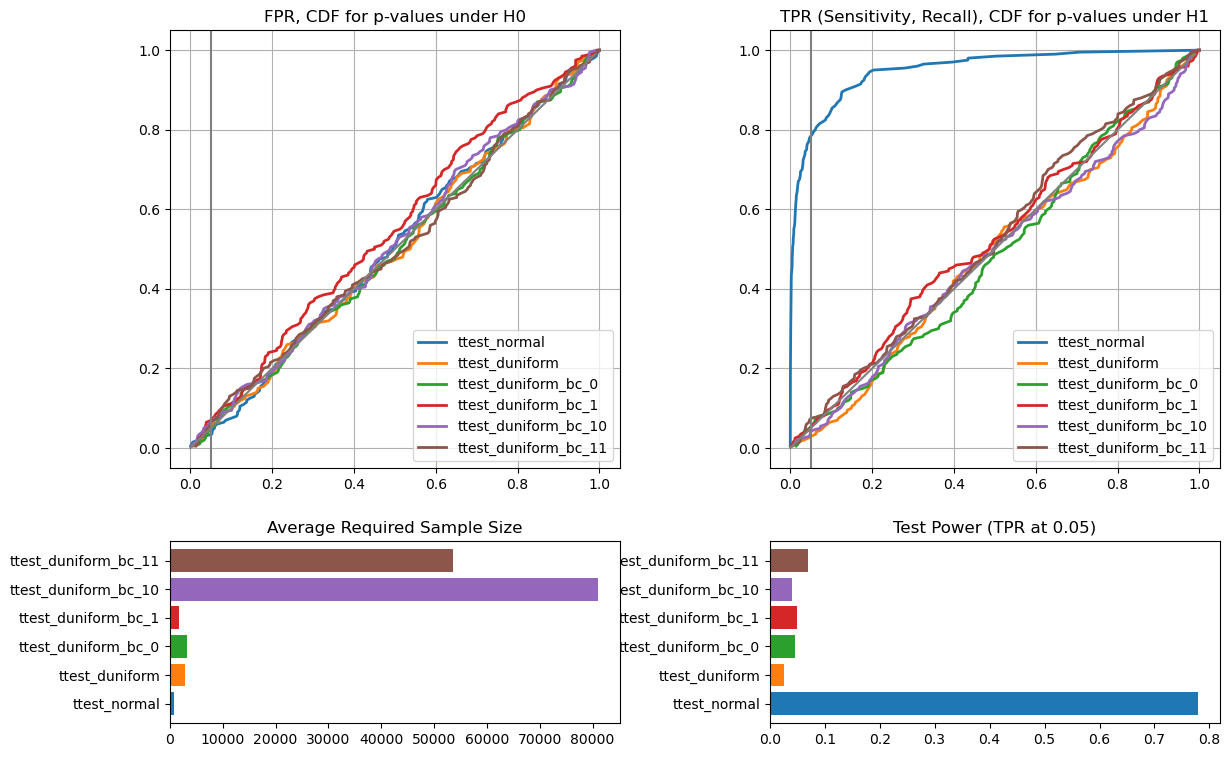

In [58]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_duniform": (
        resd[0],
        resd[1],
        resd[2],
        colors[1]
    ),
    "ttest_duniform_bc_0": (
        resd0[0],
        resd0[1],
        resd0[2],
        colors[2]
    ),
    "ttest_duniform_bc_1": (
        resd1[0],
        resd1[1],
        resd1[2],
        colors[3]
    ),
    "ttest_duniform_bc_10": (
        resd10[0],
        resd10[1],
        resd10[2],
        colors[4]
    ),
    "ttest_duniform_bc_11": (
        resd11[0],
        resd11[1],
        resd11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [59]:
# Higher mean:
mean = 15
var = np.sqrt(mean)

nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

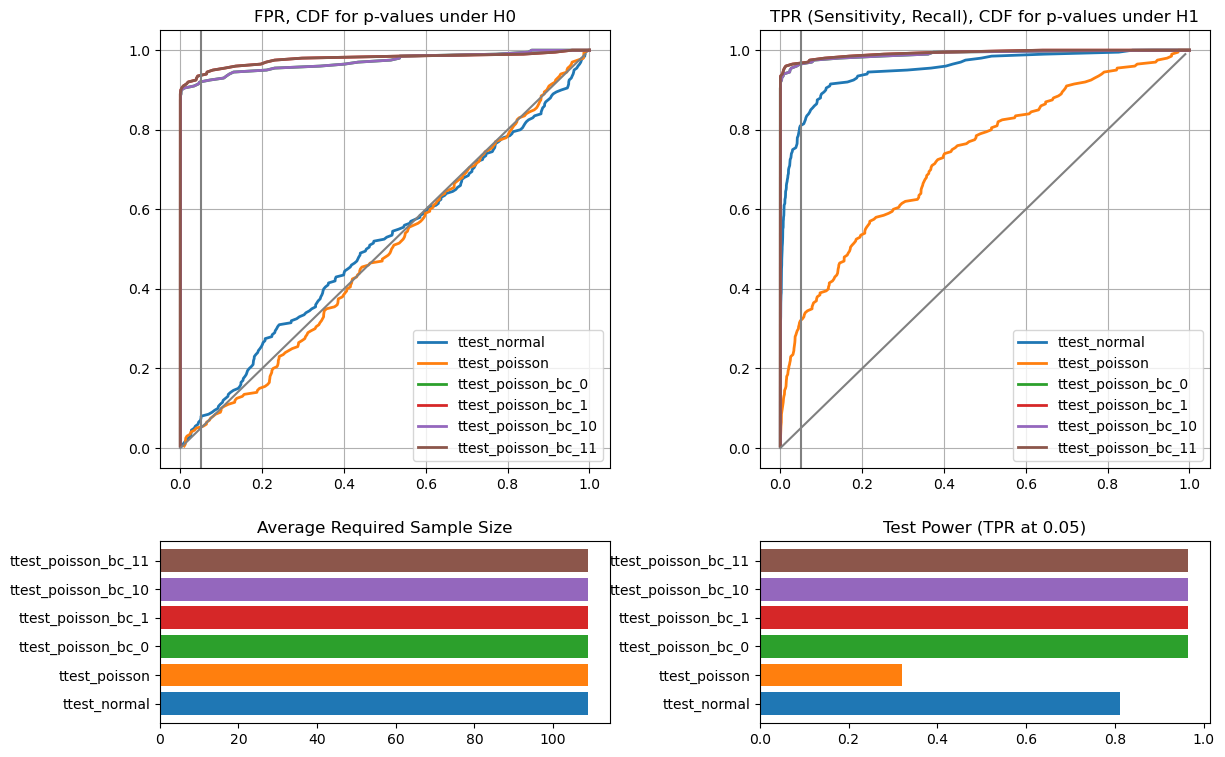

In [60]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [61]:
# Higher mean:
mean = 15
var = np.sqrt(mean)

nobs = 0 #approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, bc, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, bc, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, bc, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

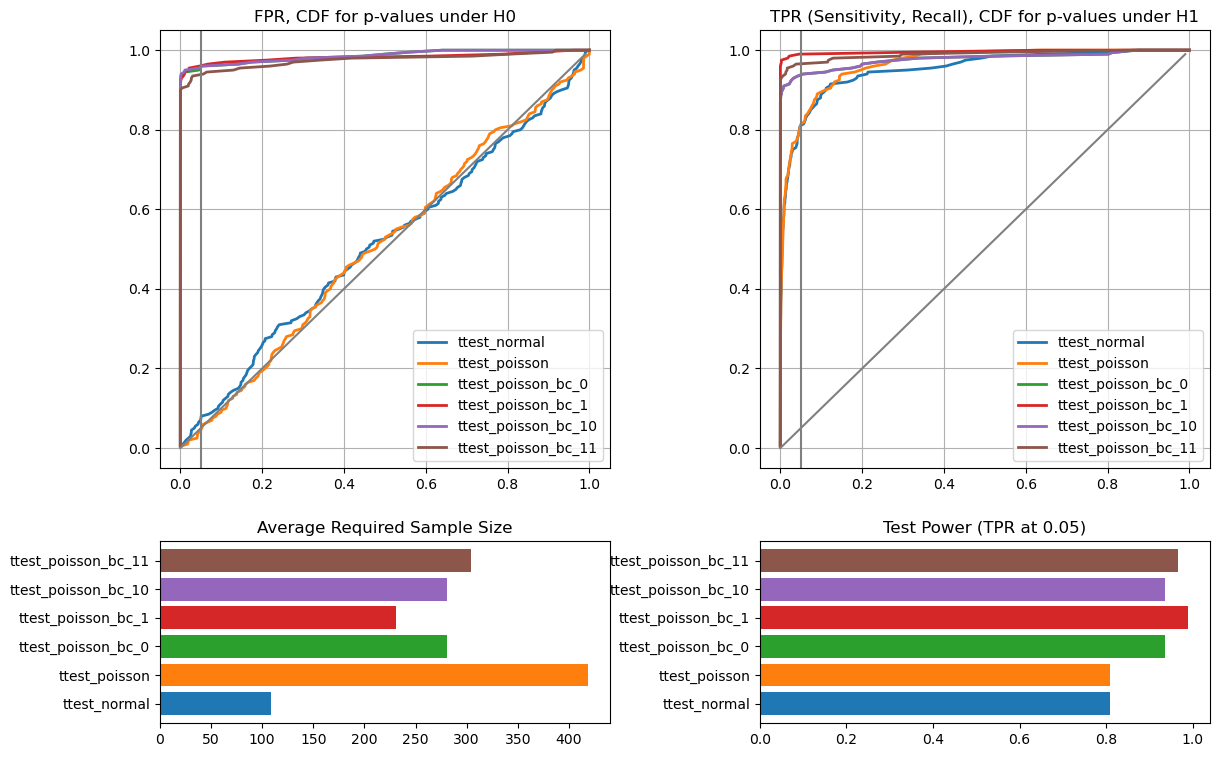

In [62]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [63]:
# Higher mean:
mean = 15
var = np.sqrt(mean)

nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

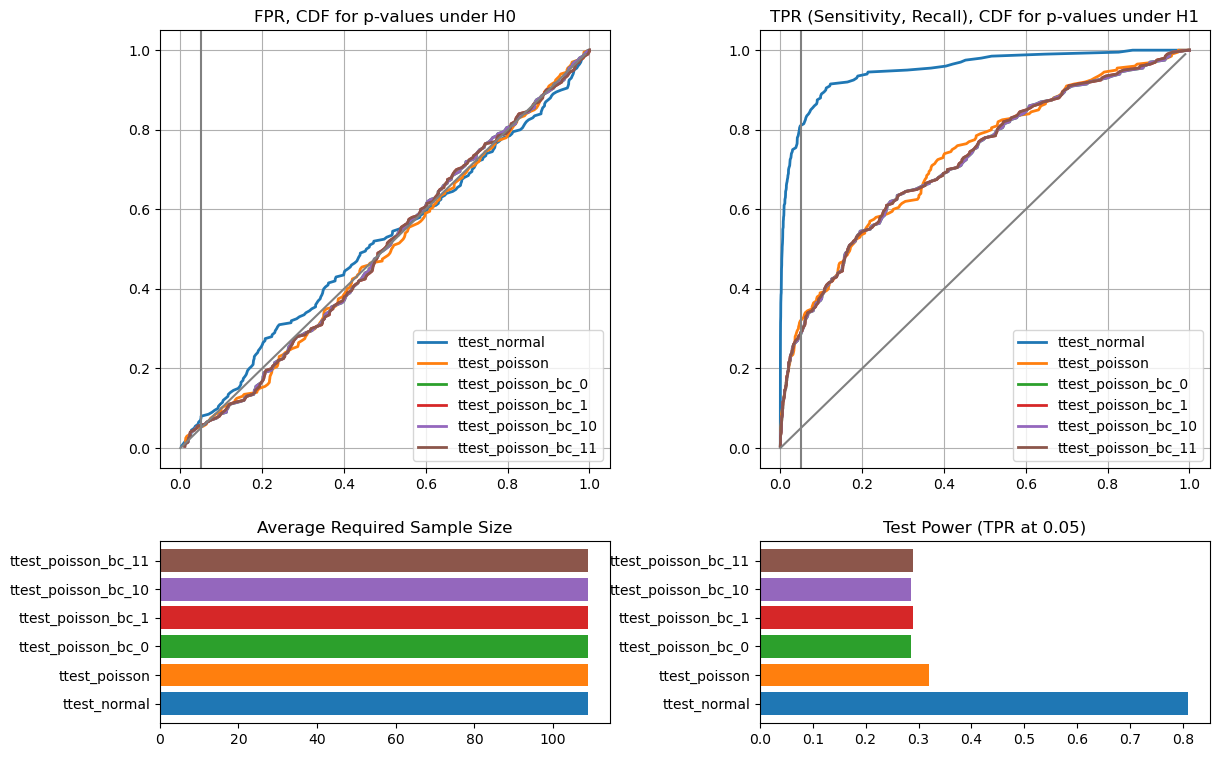

In [64]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [65]:
# Higher mean:
mean = 15
var = np.sqrt(mean)

nobs = 0 #approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp0 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp1 = complete_test(poisson, log, 1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp10 = complete_test(poisson, log, 10, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp11 = complete_test(poisson, log, 11, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

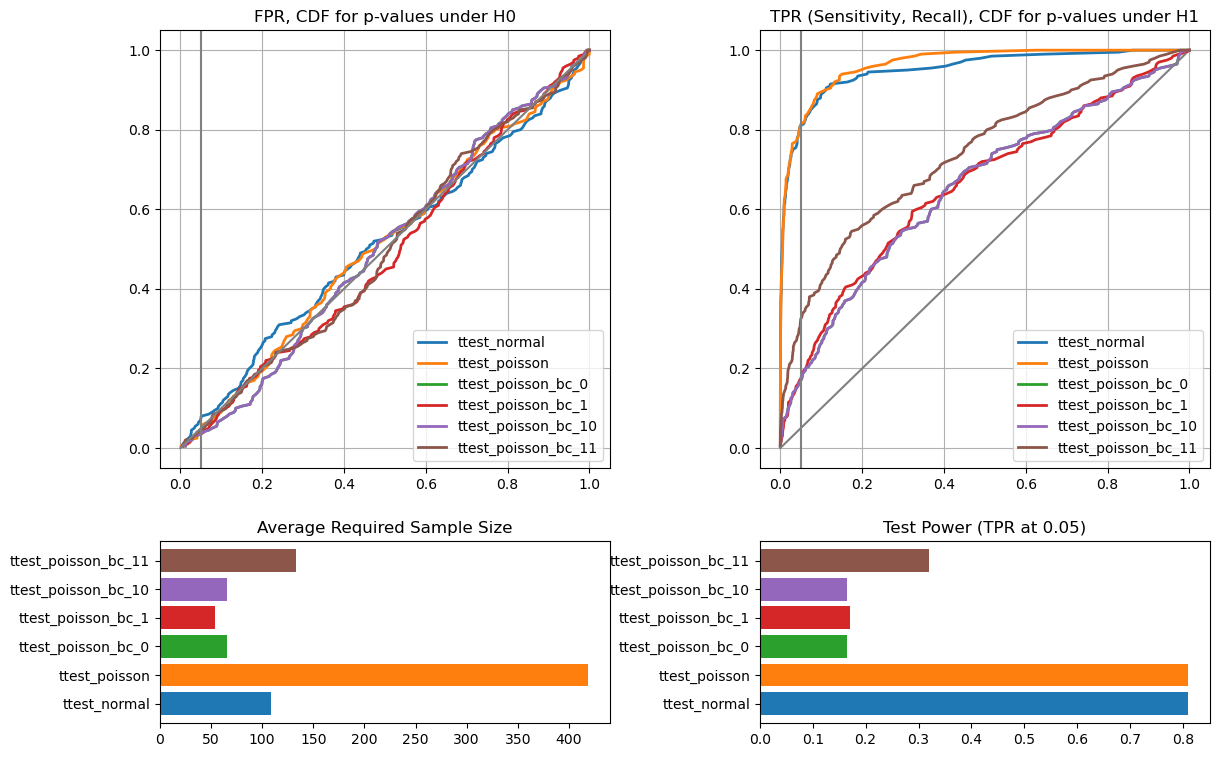

In [66]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_0": (
        resp0[0],
        resp0[1],
        resp0[2],
        colors[2]
    ),
    "ttest_poisson_bc_1": (
        resp1[0],
        resp1[1],
        resp1[2],
        colors[3]
    ),
    "ttest_poisson_bc_10": (
        resp10[0],
        resp10[1],
        resp10[2],
        colors[4]
    ),
    "ttest_poisson_bc_11": (
        resp11[0],
        resp11[1],
        resp11[2],
        colors[5]
    )
}
_ = plot_summary(test_res)

In [67]:
# But, no modifications should be valid here as well!!!

nobs = approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
respb00 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
respl00 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

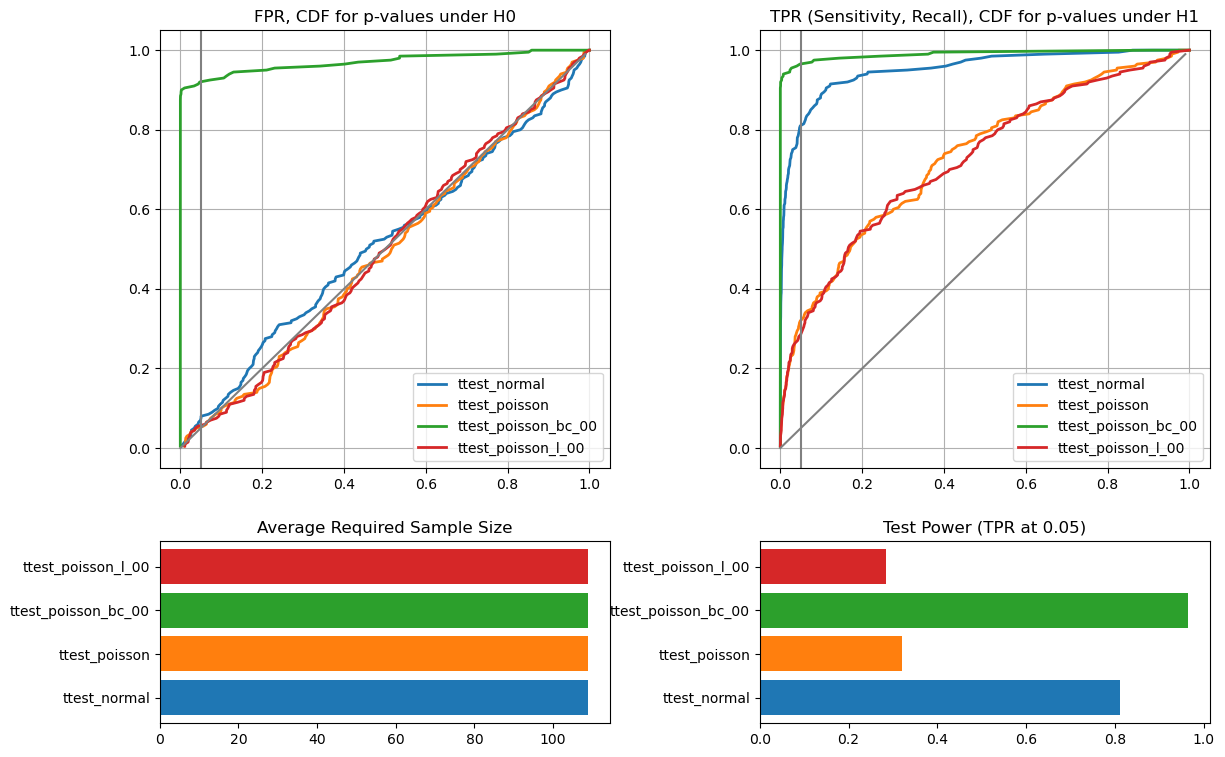

In [68]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_00": (
        respb00[0],
        respb00[1],
        respb00[2],
        colors[2]
    ),
    "ttest_poisson_l_00": (
        respl00[0],
        respl00[1],
        respl00[2],
        colors[3]
    )
}
_ = plot_summary(test_res)

In [69]:
# But, no modifications should be valid here as well!!!

nobs = 0 #approximate_points(normal, "", -1, mean, var, points, chosen_seed, mde, alpha, beta, direction)

resn = complete_test(dist, trans, mod, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
resp = complete_test(poisson, "", -1, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
respb00 = complete_test(poisson, bc, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)
respl00 = complete_test(poisson, log, 0, mean, var, points, nobs, mde, alpha, beta, direction, chosen_seed, seed_change, n_exps)

/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/patrik/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

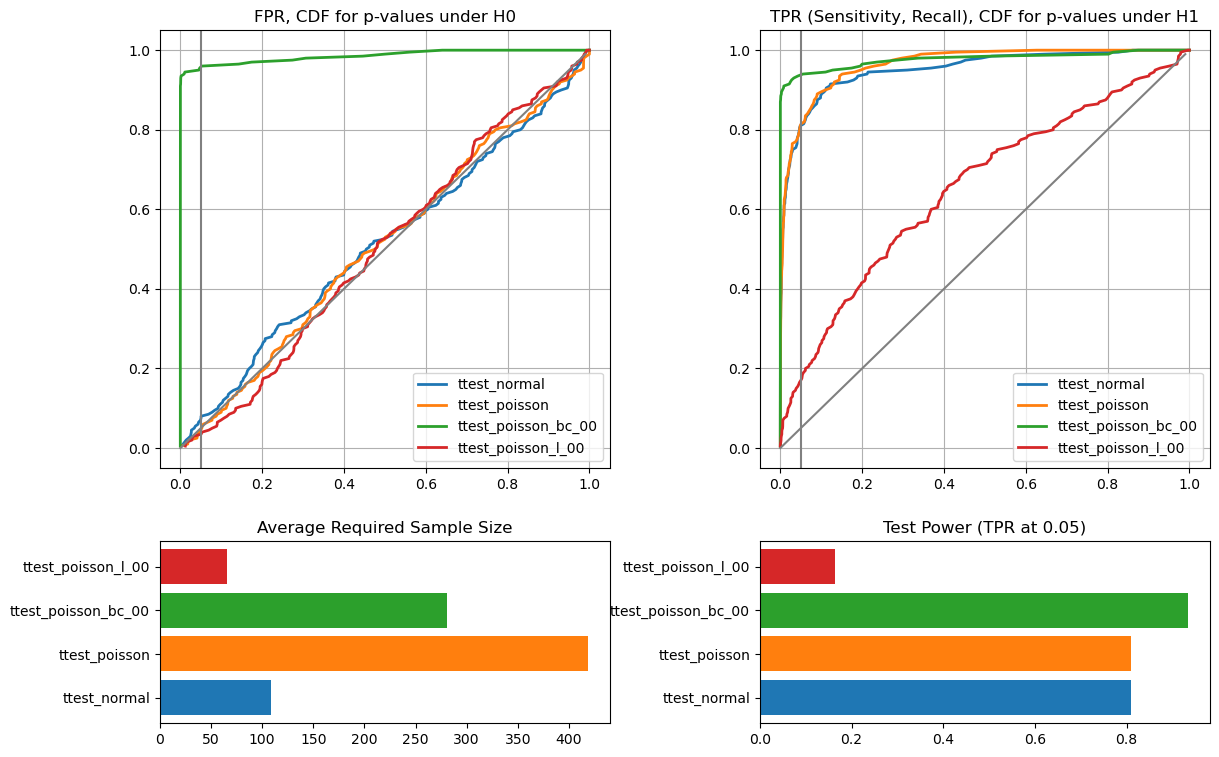

In [70]:
test_res = {
    "ttest_normal": (
        resn[0],
        resn[1],
        resn[2],
        colors[0]
    ),
    "ttest_poisson": (
        resp[0],
        resp[1],
        resp[2],
        colors[1]
    ),
    "ttest_poisson_bc_00": (
        respb00[0],
        respb00[1],
        respb00[2],
        colors[2]
    ),
    "ttest_poisson_l_00": (
        respl00[0],
        respl00[1],
        respl00[2],
        colors[3]
    )
}
_ = plot_summary(test_res)